In [53]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [35]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")

In [188]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

# Dividi il dataset in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Allinea le colonne di X_train_res e X_test per assicurarsi che abbiano le stesse colonne
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Pulizia dei nomi delle colonne per rimuovere caratteri speciali
X_train_res.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train_res.columns]
X_test.columns = X_train_res.columns  # Assicura che X_test abbia gli stessi nomi di colonne puliti
count_ones = np.sum(y_test == 1)
print("Numero di volte che y_test è uguale a 1:", count_ones)

Numero di volte che y_test è uguale a 1: 397


Dataset Normale, senza Sampling

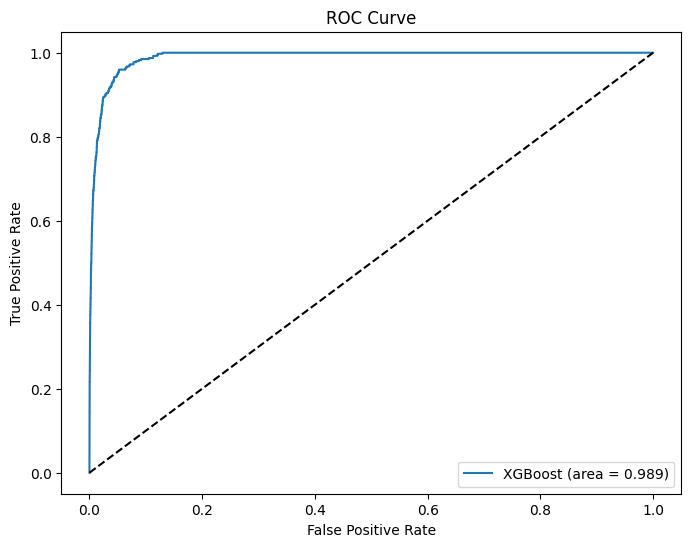

In [182]:
# Inizializza e allena il modello XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train)

# Previsioni delle probabilità sul set di test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame({
    'y_test': y_test.values,  # Utilizza .values per ottenere i valori dall'indice dell'oggetto Series
    'y_pred_proba': y_pred_proba
}, index=y_test.index)  
# Filtra per selezionare solo le istanze dove y_test è 1 (effettivamente etichettate come "SI")
results_df_si = results_df

# Ordina il DataFrame filtrato per 'y_pred_proba' in modo decrescente
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Seleziona i top 10,000 esempi
top_10000_si = results_df_si_sorted.head(10000)

# Mostra i risultati
print(top_10000_si)


        y_test  y_pred_proba
81620        0      0.998861
70155        0      0.997161
234146       0      0.995207
283449       0      0.994623
355421       0      0.993353
...        ...           ...
254321       0      0.000333
257647       0      0.000333
310050       0      0.000333
54497        0      0.000333
54399        0      0.000332

[10000 rows x 2 columns]


In [186]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nel subset di dati:", count_si)

Numero di 'SI' nel subset di dati: 53


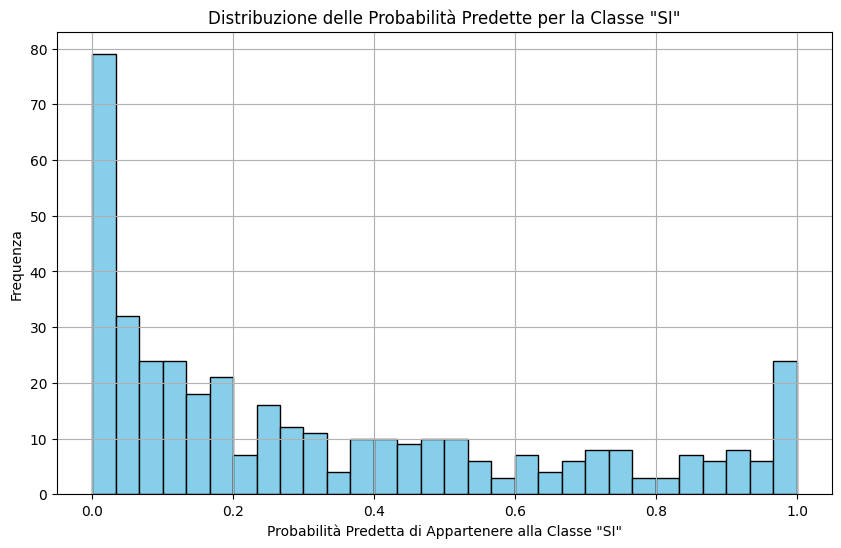

In [115]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

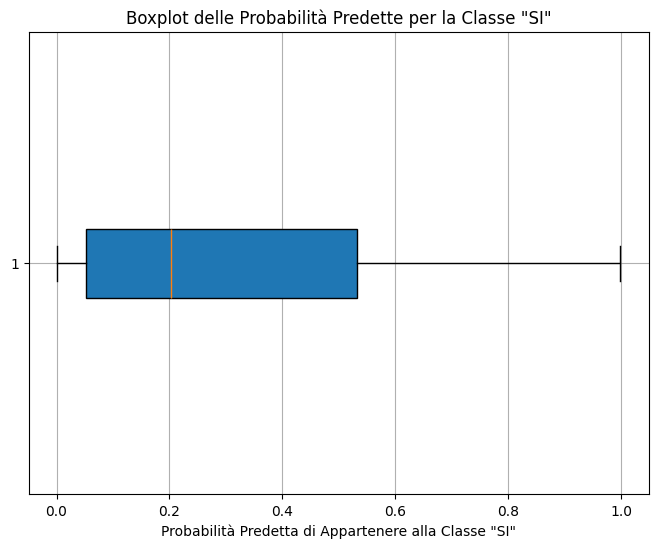

In [116]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

UnderSampling

In [195]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

# Dividi il dataset in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applica l'undersampling solo al set di training
rus = RandomUnderSampler(sampling_strategy=0.03)  # mantiene una proporzione di 1:4 tra le classi minoritarie e maggioritarie
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [196]:
print("Distribuzione delle classi nel dataset originale:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset originale:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    52866
1     1586
Name: count, dtype: int64


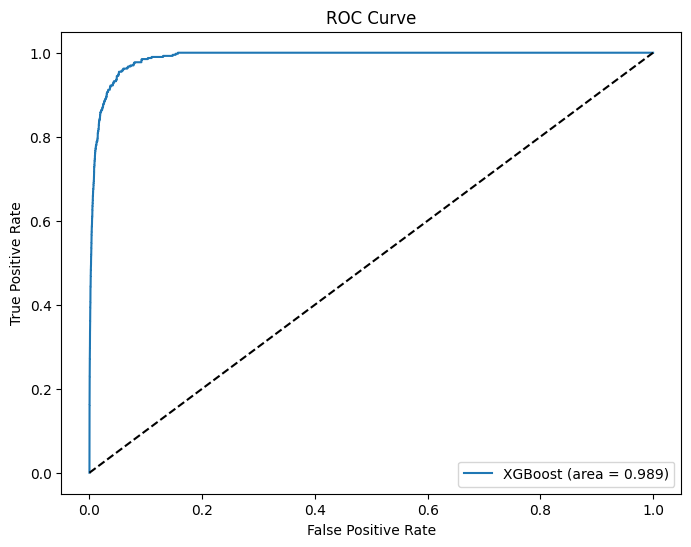

In [141]:

# Applica pd.get_dummies()
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Allinea le colonne di X_train_res e X_test per assicurarsi che abbiano le stesse colonne
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Pulizia dei nomi delle colonne per rimuovere caratteri speciali
X_train_res.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train_res.columns]
X_test.columns = X_train_res.columns  # Assicura che X_test abbia gli stessi nomi di colonne puliti

# Inizializza e allena il modello XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

# Previsioni delle probabilità sul set di test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [144]:
import pandas as pd

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

# Filtra per selezionare solo le istanze dove y_test è 1 (effettivamente etichettate come "SI")
results_df_si = results_df

# Ordina il DataFrame filtrato per 'y_pred_proba' in modo decrescente
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Seleziona i top 10,000 esempi
top_10000_si = results_df_si_sorted.head(10000)

# Mostra i risultati
print(top_10000_si)


       y_test  y_pred_proba
16643       1      0.999966
5745        1      0.999941
6322        1      0.999934
6188        1      0.999934
895         1      0.999905
...       ...           ...
14816       0      0.003947
24649       0      0.003946
57444       0      0.003946
46683       0      0.003945
67332       0      0.003945

[10000 rows x 2 columns]


In [145]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nel subset di dati:", count_si)

Numero di 'SI' nel subset di dati: 393


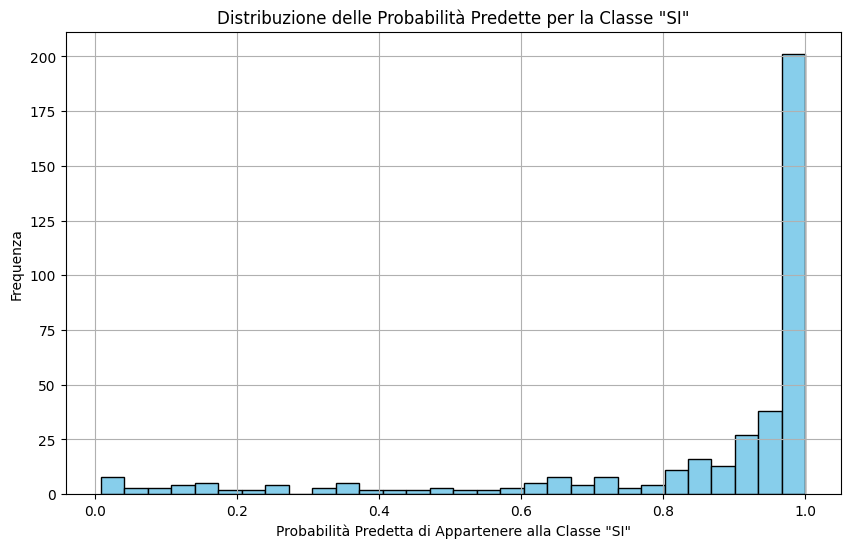

In [146]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

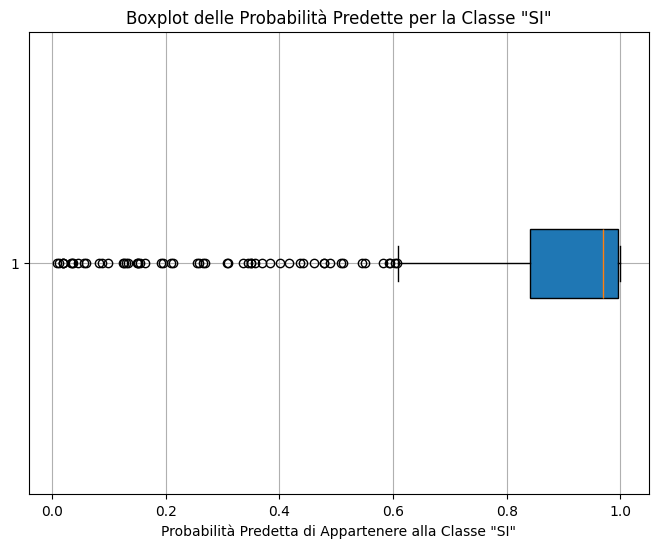

In [147]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()


OverSampling

In [156]:
from imblearn.over_sampling import RandomOverSampler

# Configurazione del Random Over Sampler
ros = RandomOverSampler(sampling_strategy=0.2)  # Qui puoi impostare la proporzione desiderata
# Applicazione del Random Over Sampler al set di training
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)


In [157]:
print("Distribuzione delle classi nel dataset bilanciato:")
print(y_train_res.value_counts())

Distribuzione delle classi nel dataset bilanciato:
Flag_Richiesta_Estinzione_cc
0    300309
1     60061
Name: count, dtype: int64


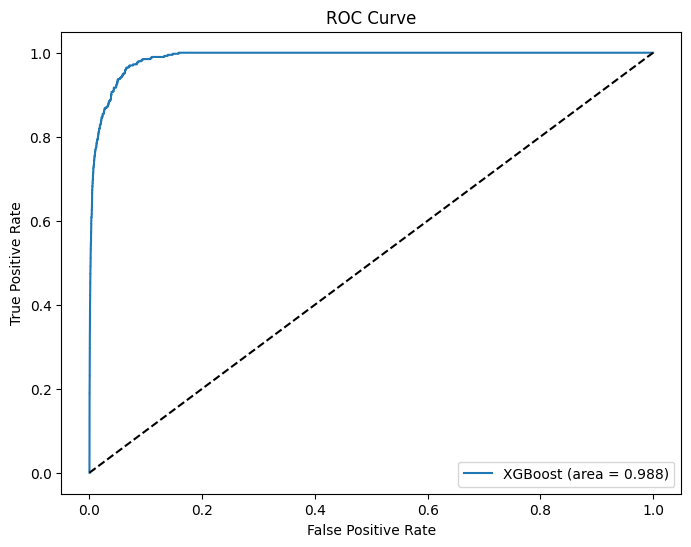

In [158]:
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Allinea le colonne di X_train_res e X_test per assicurarsi che abbiano le stesse colonne
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Pulizia dei nomi delle colonne per rimuovere caratteri speciali
X_train_res.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train_res.columns]
X_test.columns = X_train_res.columns  # Assicura che X_test abbia gli stessi nomi di colonne puliti

# Inizializza e allena il modello XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

# Previsioni delle probabilità sul set di test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [162]:
import pandas as pd

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

# Filtra per selezionare solo le istanze dove y_test è 1 (effettivamente etichettate come "SI")
results_df_si = results_df

# Ordina il DataFrame filtrato per 'y_pred_proba' in modo decrescente
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Seleziona i top 10,000 esempi
top_10000_si = results_df_si_sorted.head(10000)

# Mostra i risultati
print(top_10000_si)

       y_test  y_pred_proba
6844        1      0.999273
4927        1      0.999198
16142       1      0.999082
27147       1      0.999008
5745        1      0.998939
...       ...           ...
67858       0      0.000901
25242       0      0.000901
53838       0      0.000899
32797       0      0.000897
295         0      0.000896

[10000 rows x 2 columns]


In [163]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nel subset di dati:", count_si)

Numero di 'SI' nel subset di dati: 393


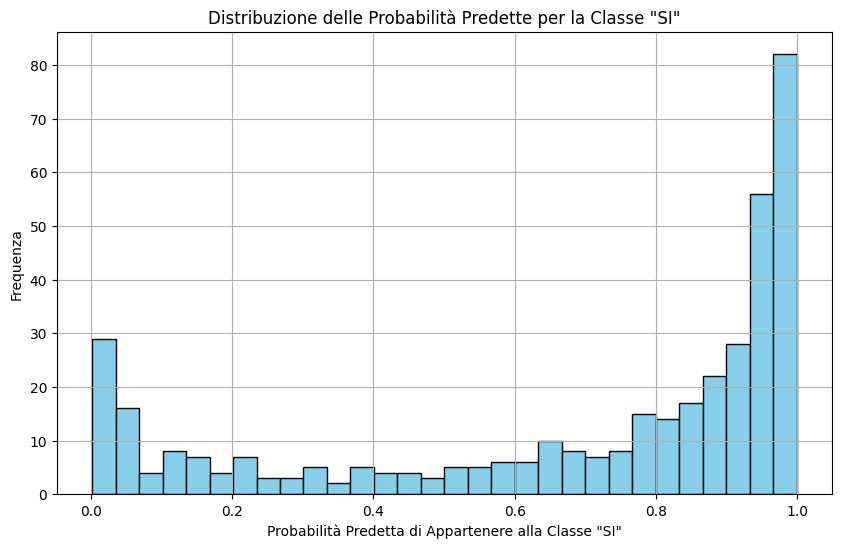

In [164]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

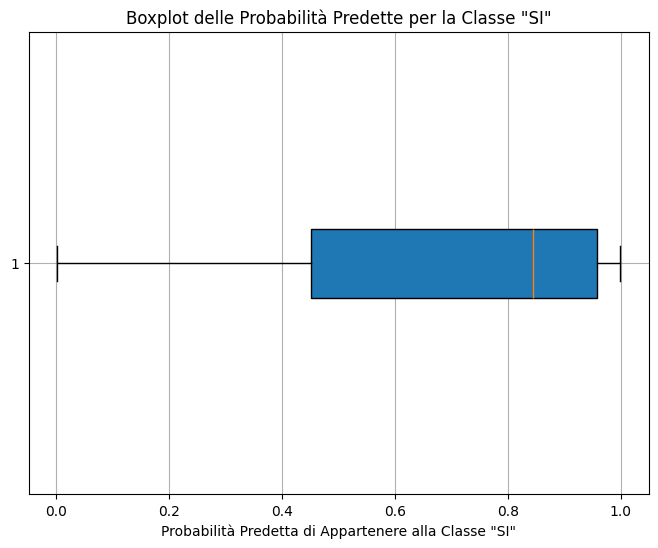

In [165]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

Balanced Boosting con Cost-Sensitive Learning

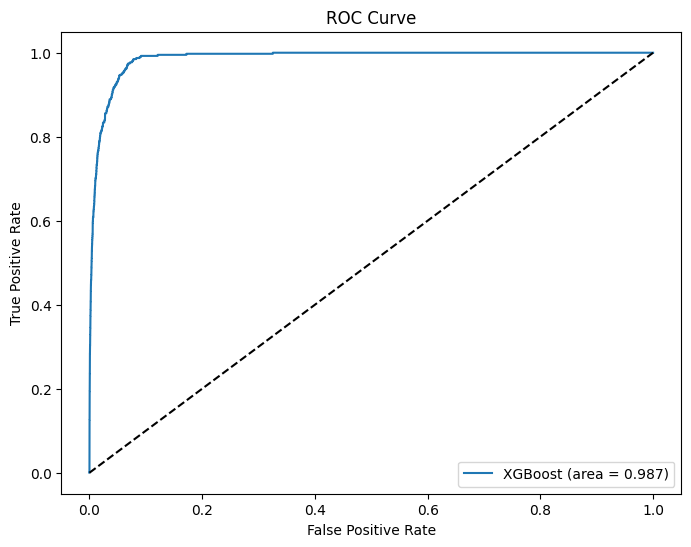

In [169]:
# Preparazione dei dati
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

# Dividi il dataset in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Allinea le colonne di X_train e X_test per assicurarsi che abbiano le stesse colonne
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Pulizia dei nomi delle colonne per rimuovere caratteri speciali
X_train.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X_train.columns]
X_test.columns = X_train.columns  # Assicura che X_test abbia gli stessi nomi di colonne puliti

# Calcola il rapporto di sbilanciamento tra le classi
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

# Inizializza e configura il modello XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# Allena il modello
model.fit(X_train, y_train)

# Previsioni delle probabilità sul set di test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [170]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

# Filtra per selezionare solo le istanze dove y_test è 1 (effettivamente etichettate come "SI")
results_df_si = results_df

# Ordina il DataFrame filtrato per 'y_pred_proba' in modo decrescente
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Seleziona i top 10,000 esempi
top_10000_si = results_df_si_sorted.head(10000)

# Mostra i risultati
print(top_10000_si)

       y_test  y_pred_proba
532         0      0.999985
6844        1      0.999853
4944        1      0.999796
27245       1      0.999777
27147       1      0.999744
...       ...           ...
63034       0      0.000816
67398       0      0.000816
72228       0      0.000814
54129       0      0.000814
51917       0      0.000814

[10000 rows x 2 columns]


In [171]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nel subset di dati:", count_si)

Numero di 'SI' nel subset di dati: 395


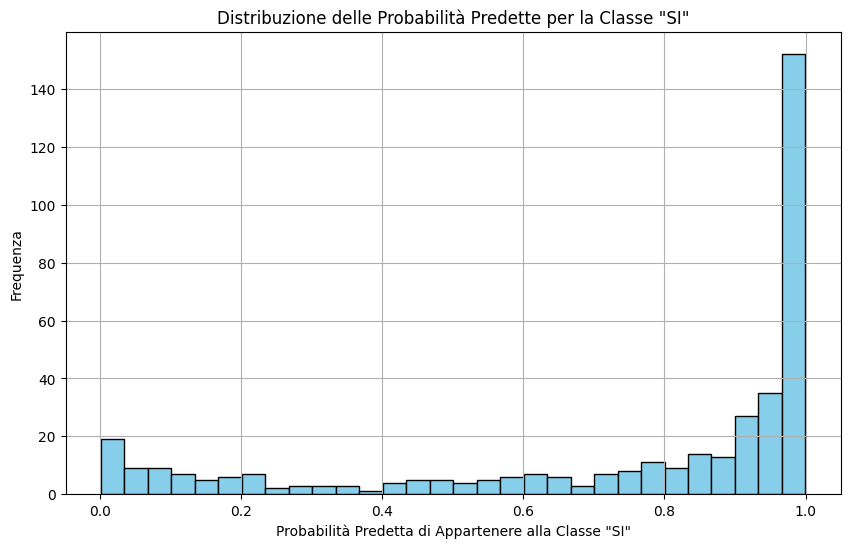

In [172]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

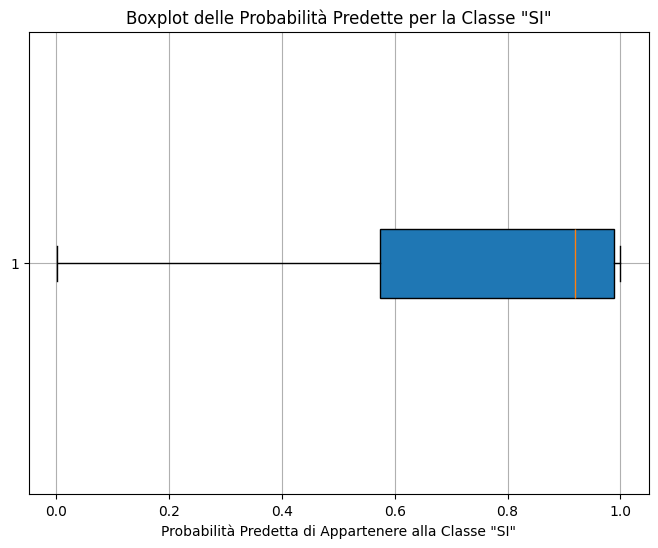

In [173]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

In [177]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Genera un dataset di esempio
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Applica il clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
clusters = kmeans.labels_

# Applica undersampling all'interno di ogni cluster
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = [], []

for i in range(kmeans.n_clusters):
    mask = clusters == i
    X_cluster, y_cluster = X[mask], y[mask]
    print(f"Cluster {i}: Classe 0 = {sum(y_cluster == 0)}, Classe 1 = {sum(y_cluster == 1)}")

    # Solo applica il sampling se entrambe le classi sono presenti
    if sum(y_cluster == 0) > 0 and sum(y_cluster == 1) > 0:
        X_res_cluster, y_res_cluster = rus.fit_resample(X_cluster, y_cluster)
        X_resampled.append(X_res_cluster)
        y_resampled.append(y_res_cluster)
    else:
        print(f"Skipping cluster {i} due to insufficient class representation.")



Cluster 0: Classe 0 = 0, Classe 1 = 178
Skipping cluster 0 due to insufficient class representation.
Cluster 1: Classe 0 = 0, Classe 1 = 225
Skipping cluster 1 due to insufficient class representation.
Cluster 2: Classe 0 = 100, Classe 1 = 12
Cluster 3: Classe 0 = 0, Classe 1 = 218
Skipping cluster 3 due to insufficient class representation.
Cluster 4: Classe 0 = 0, Classe 1 = 267
Skipping cluster 4 due to insufficient class representation.


Dopo aver testato alcune tecniche per trattare i dati sbilanciati, abbiamo scelto l'UnderSampling come piu' performante in quanto riesce ad ottenere gli stessi risultati nonostante il costo computazionale sia migliore.
Andremo a considerare il parametro di soglia del sampling come hyperparametro di tuning 

E' un peccato non esser riusciti ad usare alcune tecniche di Sampling come SMOTE per quanto riguarda l'OverSampling e TomekLinks per l'UnderSampling: entrambi usano k-nearest-neighbors rispettivamente per creare nuovi campioni sintetici e rimuovere campioni di classi diversi quando sono vicini, in modo da facilitare la classificazione